In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.testing import SeqIndTester
import matplotlib
from tqdm import tqdm
import matplotlib_inline

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "CMU Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["axes.axisbelow"] = True

In [135]:
timeseries_length = 225
num_streams = 50000

e_detector_cusum = np.zeros((num_streams, timeseries_length + 1))
e_detector_sr = np.zeros((num_streams, timeseries_length + 1))

# generate sphere data
X = np.random.normal(size=(num_streams, timeseries_length, 1)) - 1
X[:, 200:, :] += 2

for t in tqdm(range(timeseries_length)):
    for k in range(num_streams):
        likelihood_ratio = np.exp(-0.5 * ((X[k, t] - 1) ** 2 - (X[k, t] + 1) ** 2))
        e_detector_cusum[k, t + 1] = likelihood_ratio * max(e_detector_cusum[k, t], 1)
        e_detector_sr[k, t + 1] = likelihood_ratio * (e_detector_sr[k, t] + 1)

100%|██████████| 225/225 [00:56<00:00,  3.98it/s]


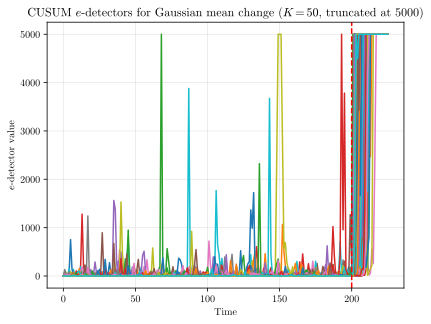

In [133]:
plt.plot(np.minimum(e_detector_cusum.T, 5000))

plt.xlabel("Time")
plt.ylabel("$e$-detector value")

plt.title("CUSUM $e$-detectors for Gaussian mean change ($K = 50$, truncated at 5000)")

plt.axvline(200, color="red", linestyle="--")

plt.grid(alpha=0.3)
plt.savefig("e-detectors-cusum.png", bbox_inches="tight")

plt.show()

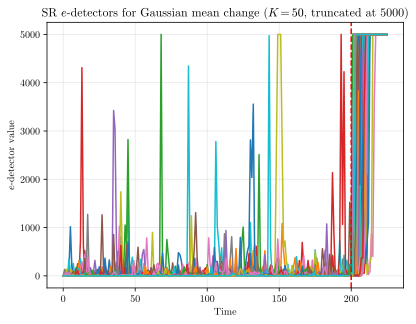

In [134]:
plt.plot(np.minimum(e_detector_sr.T, 5000))

plt.xlabel("Time")
plt.ylabel("$e$-detector value")

plt.title("SR $e$-detectors for Gaussian mean change ($K = 50$, truncated at 5000)")

plt.axvline(200, color="red", linestyle="--")

plt.grid(alpha=0.3)
plt.savefig("e-detectors-sr.png", bbox_inches="tight")

plt.show()

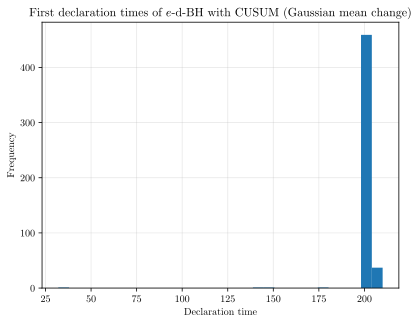

In [ ]:
alpha = 0.5

first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    order_statistics = sorted(
        zip(e_detector_cusum[:, t], range(num_streams)), key=lambda x: -x[0]
    )

    k_star = max(
        (
            k + 1
            for k in range(num_streams)
            if (k + 1) * order_statistics[k][0] / num_streams >= 1 / alpha
        ),
        default=0,
    )

    for i in range(k_star):
        if first_rejection_times[order_statistics[i][1]] == 0:
            first_rejection_times[order_statistics[i][1]] = t + 1

plt.hist(first_rejection_times, bins=30)
plt.xlabel("Declaration time")
plt.ylabel("Frequency")

plt.title("First declaration times of $e$-d-BH with CUSUM (Gaussian mean change)")
plt.grid(alpha=0.3)

plt.savefig("edbh-cusum.png", bbox_inches="tight")

plt.show()

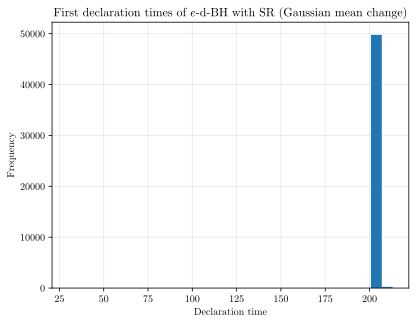

In [151]:
alpha = 0.1

first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    order_statistics = sorted(
        zip(e_detector_sr[:, t], range(num_streams)), key=lambda x: -x[0]
    )

    k_star = max(
        (
            k + 1
            for k in range(num_streams)
            if (k + 1) * order_statistics[k][0] / num_streams >= 1 / alpha
        ),
        default=0,
    )

    for i in range(k_star):
        if first_rejection_times[order_statistics[i][1]] == 0:
            first_rejection_times[order_statistics[i][1]] = t + 1

plt.hist(first_rejection_times, bins=30)
plt.xlabel("Declaration time")
plt.ylabel("Frequency")

plt.title("First declaration times of $e$-d-BH with SR (Gaussian mean change)")
plt.grid(alpha=0.3)

plt.savefig("edbh-sr-50k.png", bbox_inches="tight")

plt.show()

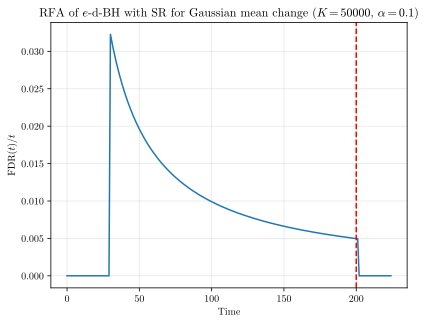

In [150]:
fdr = np.zeros(timeseries_length)
for t in range(200):
    fdr[t] = np.sum(first_rejection_times <= t) > 0

for t in range(200, timeseries_length):
    fdr[t] = np.sum(first_rejection_times <= 199) / np.sum(first_rejection_times <= t)


plt.plot(fdr / np.arange(1, timeseries_length + 1))

plt.xlabel("Time")
plt.ylabel("$\mathrm{FDR}(t) / t$")
plt.title("RFA of $e$-d-BH with SR for Gaussian mean change ($K = 50000$, $\\alpha = 0.1$)")

plt.grid(alpha=0.3)
plt.axvline(200, color="red", linestyle="--")

plt.savefig("rfa-sr.png", bbox_inches="tight")

plt.show()

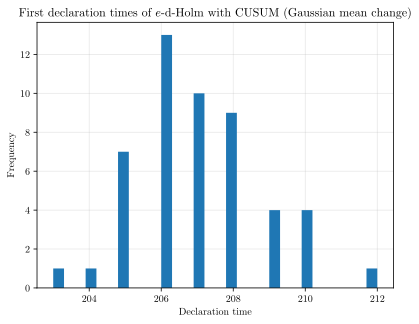

In [106]:
alpha = 0.001

first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    order_statistics = sorted(
        zip(e_detector_cusum[:, t], range(num_streams)), key=lambda x: -x[0]
    )

    k_star = max(
        (
            k
            for k in range(num_streams + 1)
            if all(
                order_statistics[i][0] / (num_streams - i) >= 1 / alpha
                for i in range(k)
            )
        ),
        default=0,
    )

    for i in range(k_star):
        if first_rejection_times[order_statistics[i][1]] == 0:
            first_rejection_times[order_statistics[i][1]] = t + 1

plt.hist(first_rejection_times, bins=30)
plt.xlabel("Declaration time")
plt.ylabel("Frequency")

plt.title("First declaration times of $e$-d-Holm with CUSUM (Gaussian mean change)")
plt.grid(alpha=0.3)

plt.savefig("edholm-cusum.png", bbox_inches="tight")

plt.show()

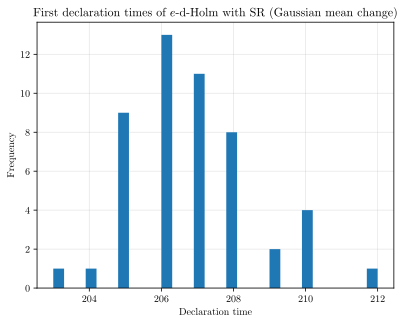

In [108]:
alpha = 0.001

first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    order_statistics = sorted(
        zip(e_detector_sr[:, t], range(num_streams)), key=lambda x: -x[0]
    )

    k_star = max(
        (
            k
            for k in range(num_streams + 1)
            if all(
                order_statistics[i][0] / (num_streams - i) >= 1 / alpha
                for i in range(k)
            )
        ),
        default=0,
    )

    for i in range(k_star):
        if first_rejection_times[order_statistics[i][1]] == 0:
            first_rejection_times[order_statistics[i][1]] = t + 1

plt.hist(first_rejection_times, bins=30)
plt.xlabel("Declaration time")
plt.ylabel("Frequency")

plt.title("First declaration times of $e$-d-Holm with SR (Gaussian mean change)")
plt.grid(alpha=0.3)

plt.savefig("edholm-sr.png", bbox_inches="tight")

plt.show()

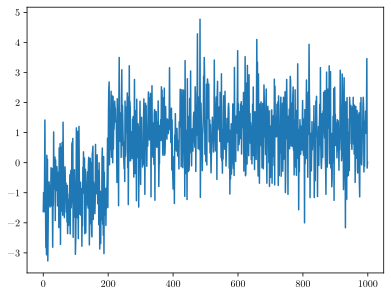

In [55]:
plt.plot(X[-1, :])